In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import torch
from typing import Literal, TypedDict

In [2]:
sys.path.append("..")
os.environ["USER_PATH"] = "../userdata/"

In [3]:
from system.namespace.store import get_namespace

In [4]:
namespace = get_namespace("test_new")

In [5]:
prefix = "final_"

In [6]:
from system.embedding.store import get_embed_store
from misc.lru import LRU

In [7]:
embeds = get_embed_store(namespace)

In [8]:
role_c = "child"
role_p = "parent"

In [9]:
total_c = embeds.get_embedding_count(role_c)
total_c

488837

In [10]:
total_p = embeds.get_embedding_count(role_p)
total_p

488837

In [11]:
from sklearn.manifold import TSNE

In [12]:
%%time

x_0 = np.vstack([
    embed[1].ravel().detach().numpy()
    for embed in embeds.get_all_embeddings(role_c, progress_bar=True)
])
y_0 = x_0.shape[0]
x_1 = np.vstack([
    embed[1].ravel().detach().numpy()
    for embed in embeds.get_all_embeddings(role_p, progress_bar=True)
])
y_1 = x_1.shape[0]
y = [
    "tab:blue" for _ in range(y_0)
] + [
    "tab:orange" for _ in range(y_1)
]
x = np.vstack([x_0, x_1])
x.shape

  0%|          | 0/488837 [00:00<?, ?it/s]

  0%|          | 0/488837 [00:00<?, ?it/s]

CPU times: user 3min 11s, sys: 27.9 s, total: 3min 38s
Wall time: 4min 11s


(977674, 768)

In [13]:
x[:5, :]

array([[-0.08400214, -0.00734976,  0.1894109 , ...,  0.41254967,
        -0.01996108,  0.0439146 ],
       [-0.07990441,  0.01742382,  0.22730318, ...,  0.40153447,
         0.03086621,  0.03788832],
       [-0.08012579,  0.0162152 ,  0.22546417, ...,  0.40210262,
         0.02827096,  0.03815467],
       [-0.07944432,  0.02052144,  0.23177454, ...,  0.40001845,
         0.03711501,  0.03720045],
       [-0.07959864,  0.01946645,  0.23026484, ...,  0.4005363 ,
         0.03499285,  0.03743086]])

In [14]:
aa_count = 15000
aa = x[list(range(aa_count)) + list(range(total_c, total_c + aa_count)), :]
aa_y = [
    "tab:blue" for _ in range(aa_count)
] + [
    "tab:orange" for _ in range(aa_count)
]
aa.shape

(30000, 768)

In [15]:
aa[:5, :]

array([[-0.08400214, -0.00734976,  0.1894109 , ...,  0.41254967,
        -0.01996108,  0.0439146 ],
       [-0.07990441,  0.01742382,  0.22730318, ...,  0.40153447,
         0.03086621,  0.03788832],
       [-0.08012579,  0.0162152 ,  0.22546417, ...,  0.40210262,
         0.02827096,  0.03815467],
       [-0.07944432,  0.02052144,  0.23177454, ...,  0.40001845,
         0.03711501,  0.03720045],
       [-0.07959864,  0.01946645,  0.23026484, ...,  0.4005363 ,
         0.03499285,  0.03743086]])

In [16]:
aa[aa_count - 1:aa_count + 4,:]

array([[-0.07978046,  0.01824458,  0.22849911, ...,  0.40113443,
         0.03252729,  0.03770279],
       [-0.06838648,  0.04911917,  0.00593609, ...,  0.40966463,
         0.07171547, -0.00541118],
       [-0.06882811,  0.04546746,  0.00863482, ...,  0.41149807,
         0.06932123, -0.00783911],
       [-0.0683879 ,  0.04910633,  0.00594559, ...,  0.40967172,
         0.07170688, -0.00541995],
       [-0.06856252,  0.04757288,  0.00707766, ...,  0.41047567,
         0.07068976, -0.00645498]])

In [17]:
x = None
y = None

In [18]:
def angle_color(xs, ys):
    dx = xs[1] - xs[0]
    sq_length = (xs[1] - xs[0])**2 + (ys[1] - ys[0])**2
    if np.isclose(sq_length, 0.0):
        res = 0.0
    else:
        dxnorm = dx / np.sqrt(sq_length)
        res = np.rad2deg(np.arccos(dxnorm))
        if ys[1] > ys[0]:
            res = 360.0 - res
        res /= 360.0
    return hsv_to_rgb([res, 0.8, 0.8])

In [19]:
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

def distance(a, b):
    return np.log1p(np.exp(-np.dot(a, b)))
    # return 1.0 - sigmoid(np.dot(a, b))

In [20]:
force_recompute = False
outfile = f"{prefix}tsne2.pq"

In [21]:
%%time

if force_recompute or not os.path.exists(outfile):
    aa_embedded = TSNE(
        n_components=2,
        learning_rate="auto",
        init="random",
        # perplexity=10,
        method="barnes_hut",
        random_state=42,
        metric=distance,
        n_jobs=-1).fit_transform(aa)
    df = pd.DataFrame({"x": aa_embedded[:, 0], "y": aa_embedded[:, 1], "l": aa_y})
    df.to_parquet(outfile)
    display(aa_embedded.shape)
    display(df.head())
else:
    df = pd.read_parquet(outfile)
    display(df.head())

(30000, 2)

,x,y,l
0,-34.632298,4.475427,tab:blue
1,-12.267966,8.010939,tab:blue
2,-22.985273,15.269339,tab:blue
3,-14.195929,6.360881,tab:blue
4,-19.076979,16.771048,tab:blue


CPU times: user 1h 23min 36s, sys: 1h 29min 31s, total: 2h 53min 8s
Wall time: 1h 36min 9s


In [22]:
df.iloc[aa_count - 1:, :].head()

,x,y,l
14999,-20.912289,3.702198,tab:blue
15000,17.867828,-12.505561,tab:orange
15001,26.347473,-1.325350,tab:orange
15002,16.216946,-16.853889,tab:orange
15003,20.688126,-12.972568,tab:orange


In [23]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import hsv_to_rgb

In [24]:
# tmp_count = 100
# tmp = df.copy().iloc[list(range(tmp_count)) + list(range(total_c, total_c + tmp_count)), :]
# tmp.shape
tmp_count = aa_count
tmp = df.copy()
tmp.shape

(30000, 3)

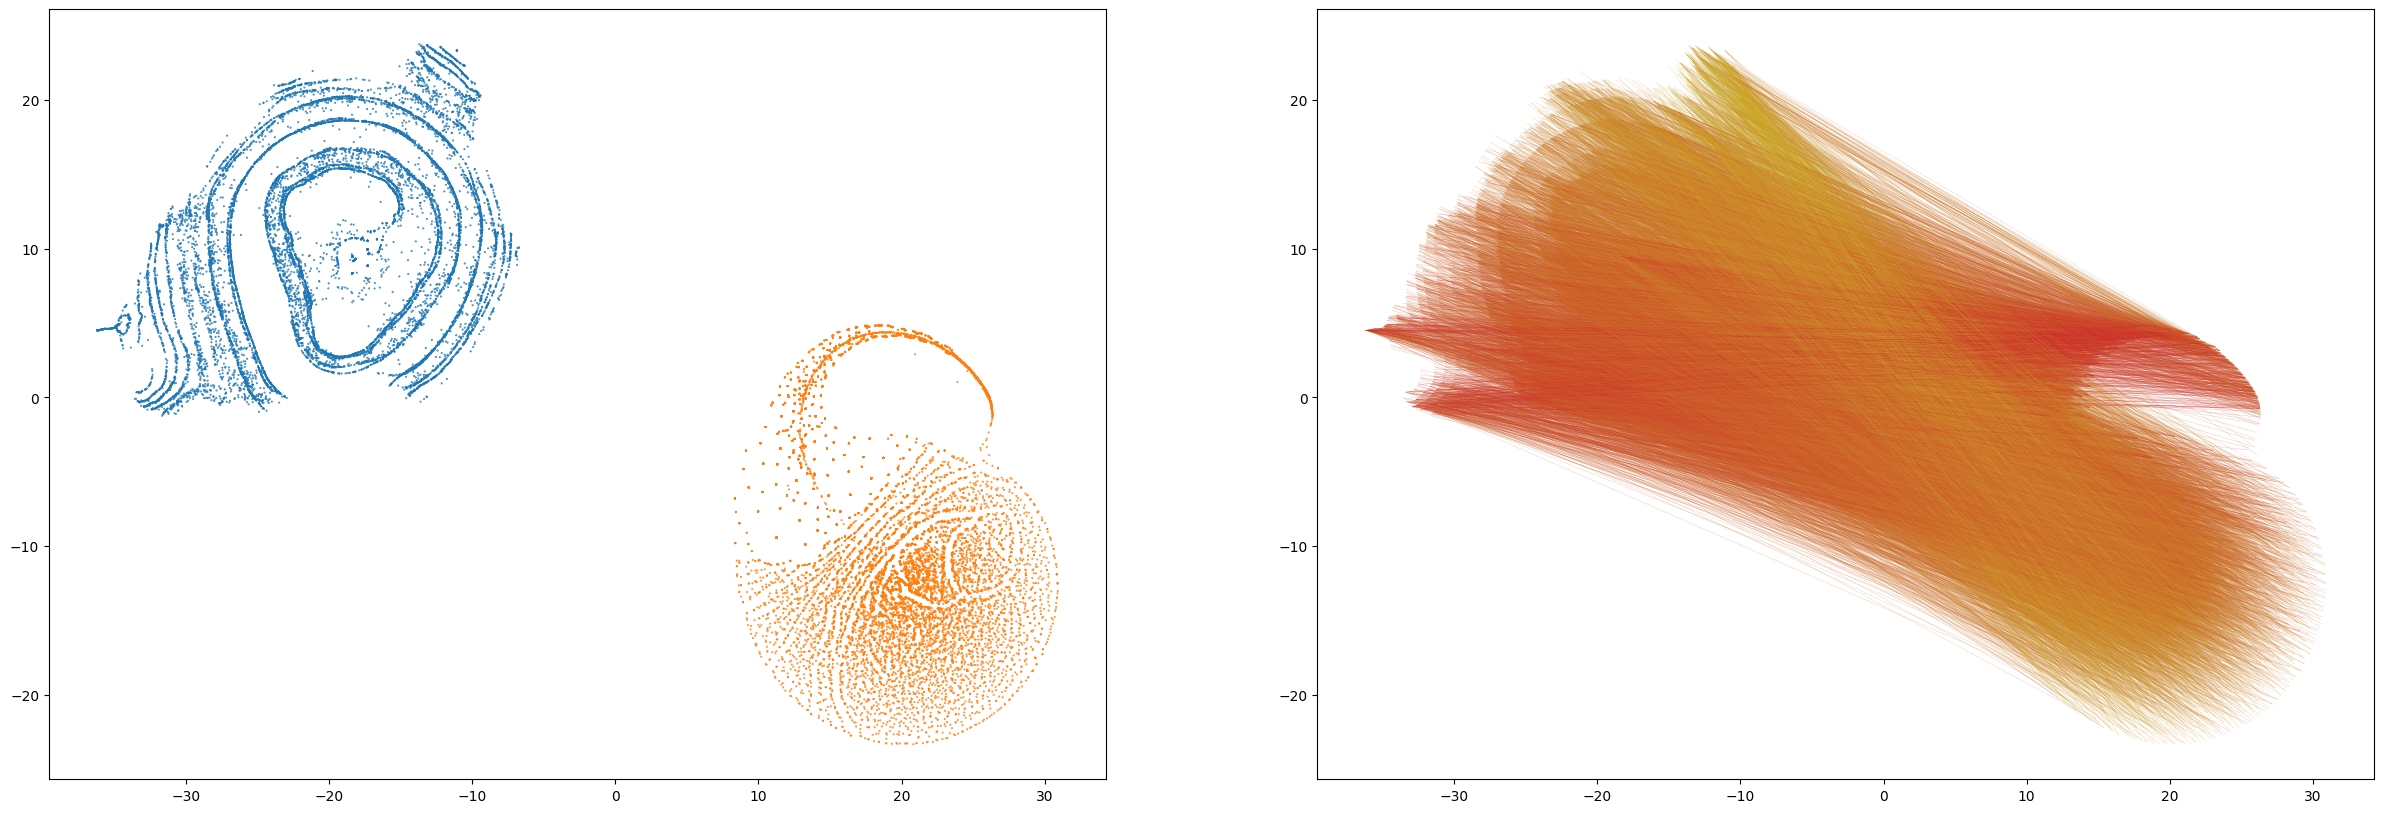

In [25]:
fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_left)
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    alpha=0.0,
    xlabel="",
    ylabel="",
    ax=ax_right)
for ix in range(tmp_count):
    xs = (tmp["x"].iloc[ix], tmp["x"].iloc[ix + tmp_count])
    ys = (tmp["y"].iloc[ix], tmp["y"].iloc[ix + tmp_count])
    ax_right.add_line(Line2D(
        xs,
        ys,
        # alpha=0.5,
        lw=0.1,
        c=angle_color(xs, ys)))
plt.savefig(f"{prefix}full_log1pexpneg.png", bbox_inches="tight")
plt.show()

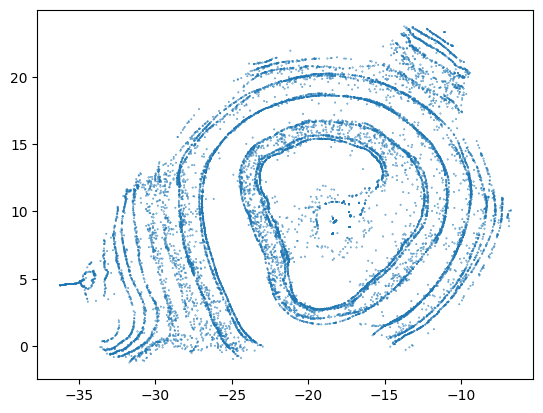

In [26]:
tmp.iloc[:tmp_count, :].plot.scatter(
    x="x",
    y="y",
    s=0.1,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="")
plt.savefig(f"{prefix}child_log1pexpneg.png", bbox_inches="tight")
plt.show()

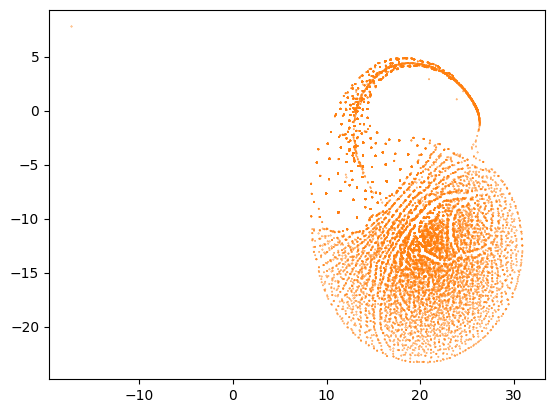

In [27]:
tmp.iloc[tmp_count:, :].plot.scatter(
    x="x",
    y="y",
    s=0.1,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="")
plt.savefig(f"{prefix}parent_log1pexpneg.png", bbox_inches="tight")
plt.show()

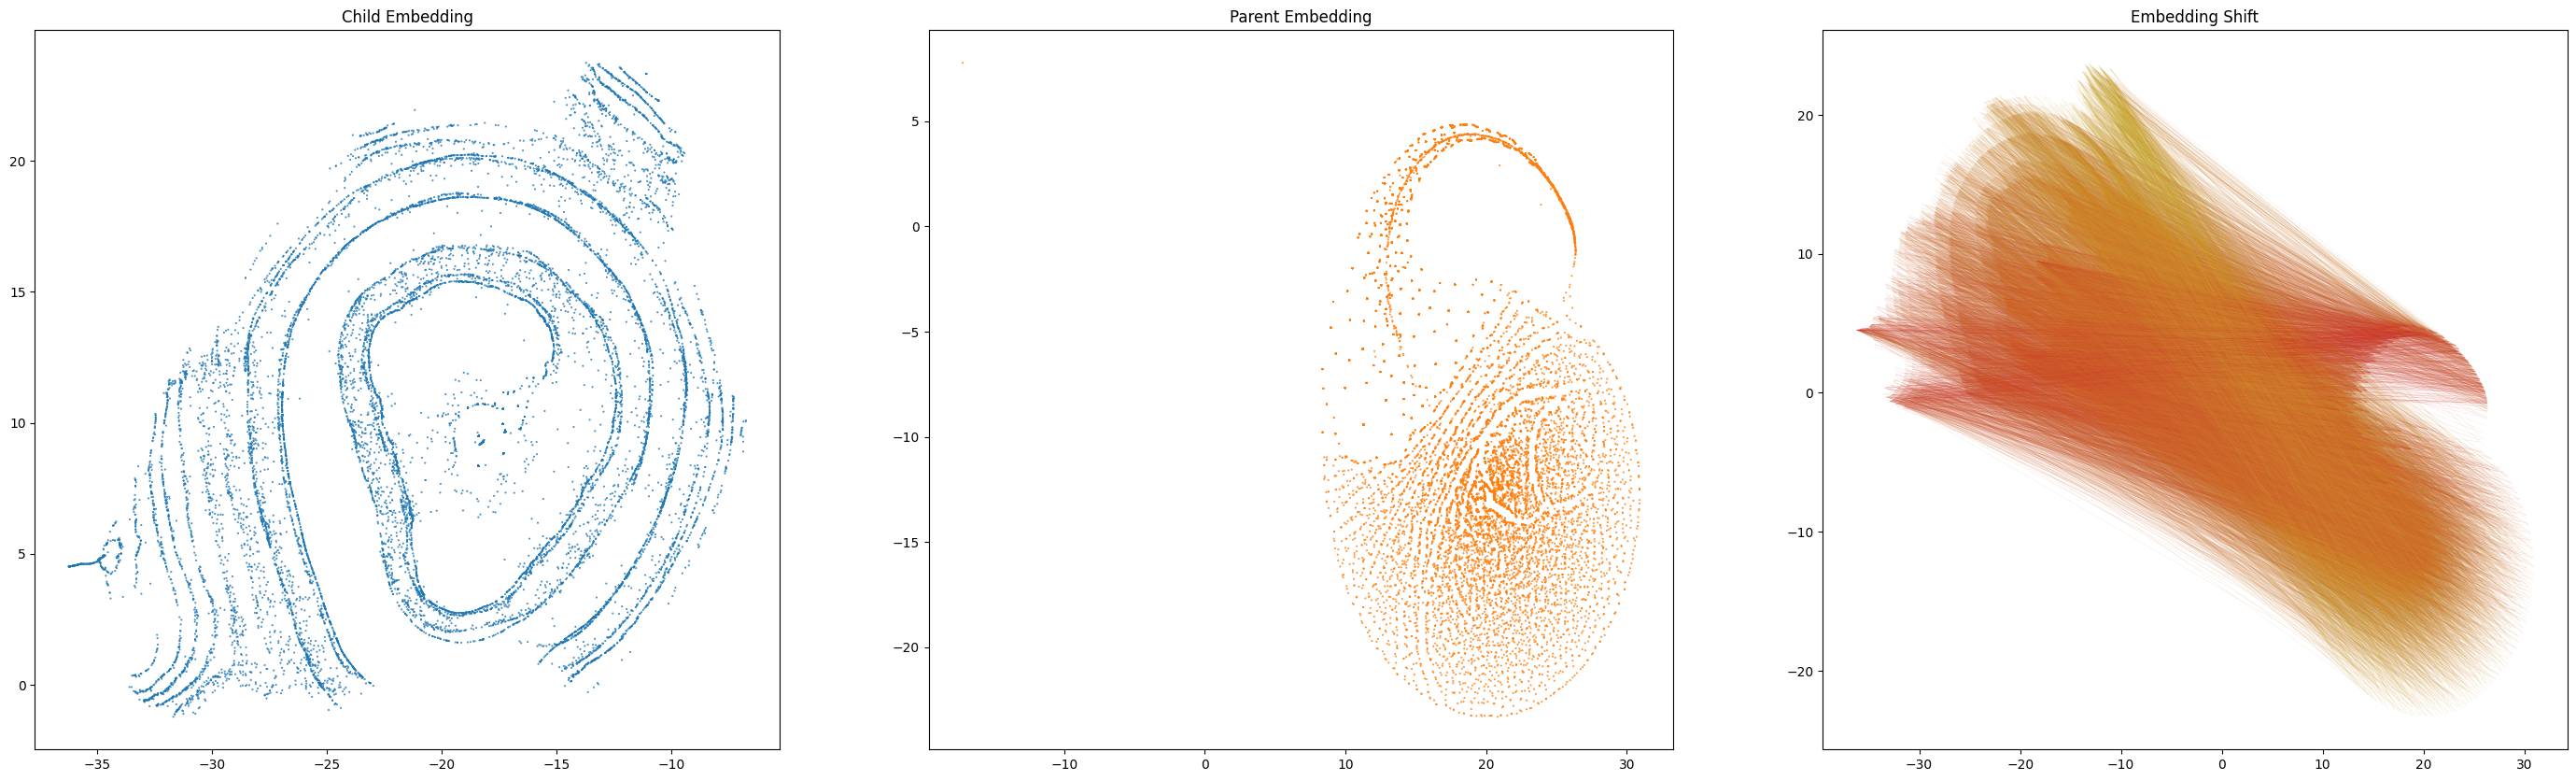

In [28]:
fig, (ax_left, ax_mid, ax_right) = plt.subplots(nrows=1, ncols=3, figsize=(35, 10))
tmp[tmp["l"] == "tab:blue"].plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_left,
    title="Child Embedding")
tmp[tmp["l"] == "tab:orange"].plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_mid,
    title="Parent Embedding")
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    alpha=0.0,
    xlabel="",
    ylabel="",
    ax=ax_right,
    title="Embedding Shift")
for ix in range(tmp_count):
    xs = (tmp["x"].iloc[ix], tmp["x"].iloc[ix + tmp_count])
    ys = (tmp["y"].iloc[ix], tmp["y"].iloc[ix + tmp_count])
    ax_right.add_line(Line2D(
        xs,
        ys,
        alpha=0.5,
        lw=0.1,
        c=angle_color(xs, ys)))
plt.savefig(f"{prefix}tri_log1pexpneg.png", bbox_inches="tight")
plt.show()

In [29]:
# k * n log(n) = t
total_time = ((11 * 60.0) + 50 * 60) + 3
k = total_time / (total_c * np.log(total_c))
new_size = 50000
k * new_size * np.log(new_size)

309.454688477229

In [30]:
# tt_count = 15000
# tt = x[list(range(tt_count)) + list(range(total_c, total_c + tt_count)), :]
# tt_y = [
#     "tab:blue" for _ in range(tt_count)
# ] + [
#     "tab:orange" for _ in range(tt_count)
# ]
# tt.shape

In [31]:
# %%time

# tt_embedded = TSNE(
#     n_components=2,
#     learning_rate="auto",
#     init="random",
#     perplexity=10,
#     method="barnes_hut",
#     random_state=42,
#     # metric="cosine",
#     n_jobs=-1).fit_transform(tt)

In [32]:
# t_df = pd.DataFrame({"x": tt_embedded[:, 0], "y": tt_embedded[:, 1], "l": tt_y})
# t_df.head()

In [33]:
# fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
# t_df.plot.scatter(
#     x="x",
#     y="y",
#     s=0.2,
#     c="l",
#     # alpha=0.1,
#     xlabel="",
#     ylabel="",
#     ax=ax_left)
# t_df.plot.scatter(
#     x="x",
#     y="y",
#     s=0.2,
#     c="l",
#     alpha=0,
#     xlabel="",
#     ylabel="",
#     ax=ax_right)
# for ix in range(tt_count):
#     xs = (t_df["x"].iloc[ix], t_df["x"].iloc[ix + tt_count])
#     ys = (t_df["y"].iloc[ix], t_df["y"].iloc[ix + tt_count])
#     ax_right.add_line(Line2D(
#         xs,
#         ys,
#         # alpha=0.05,
#         lw=0.1,
#         c=angle_color(xs, ys)))
# plt.savefig("subset_euclid.png", bbox_inches="tight")
# plt.show()